In [201]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from scipy.linalg import sqrtm
from scipy.linalg import inv
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_t
from sklearn.cluster import KMeans

def mult_mix_plot_Kmeans(file_name):

    name = file_name[:-4]
    name = name[0].upper() + name[1:]
    data = pd.read_csv(file_name, header=None)
    data = data.dropna()
    data.columns = ['Exit Velocity','Launch Angle']

    cluster_num = 2
    data['cluster id'] = KMeans(n_clusters=cluster_num).fit(data).predict(data)
    
    clusters = []
    for i in range(cluster_num):
        clusters.append(data[data['cluster id']==i])

    cluster_dists = []
    for cluster in clusters:
        cluster_dists.append(multivariate_normal(mean = [cluster['Exit Velocity'].mean(), cluster['Launch Angle'].mean()], cov = cluster[['Exit Velocity', 'Launch Angle']].cov()))

    X, Y = np.mgrid[data['Exit Velocity'].min() - 10:data['Exit Velocity'].max() + 10:1, 
                    data['Launch Angle'].min() - 10:data['Launch Angle'].max() + 10:1]
    
    pos = np.dstack((X,Y))

    Z = 0
    for i in range(cluster_num):
        Z += (clusters[i].shape[0] / data.shape[0]) * cluster_dists[i].pdf(pos)
    
    plt.contourf(X, Y, Z,levels=100,cmap='rocket')
    plt.scatter(x=data['Exit Velocity'], y=data['Launch Angle'], alpha=0.2, c='white')
    plt.xlabel('Exit Velocity')
    plt.ylabel('Launch Angle')
    plt.title('')
    if (name[-1] == 's'):
        plt.title(name + "' Probability Density Estimate")
    else: 
        plt.title(name + "'s Probability Density Estimate")
    plt.show()

def mult_mix_plot_low_prob(file_name):
    
    #read in data
    name = file_name[:-4]
    name = name[0].upper() + name[1:]
    data = pd.read_csv(file_name, header=None)
    data = data.dropna()
    data.columns = ['Exit Velocity','Launch Angle']

    main_cov_matrix = data.cov()
    main_velo_mean = data['Exit Velocity'].mean()
    main_angle_mean = data['Launch Angle'].mean()

    X, Y = np.mgrid[data['Exit Velocity'].min() - 10:data['Exit Velocity'].max() + 10:1, 
                data['Launch Angle'].min() - 10:data['Launch Angle'].max() + 10:1]
    
    pos = np.dstack((X,Y))

    main_mult_dist = multivariate_normal(mean = [main_velo_mean, main_angle_mean], cov = main_cov_matrix)

    low_probs_index = []
    for i in range(data.shape[0]):
        if (main_mult_dist.pdf(data.iloc[i,:]) < 0.000001):
            low_probs_index.append(i)

    low_prob_data = data.iloc[low_probs_index]

    low_prob_cov_matrix = data.cov()
    low_prob_velo_mean = low_prob_data['Exit Velocity'].mean()
    low_prob_angle_mean = low_prob_data['Launch Angle'].mean()

    low_prob_mult_dist = multivariate_normal(mean = [low_prob_velo_mean, low_prob_angle_mean], cov = low_prob_cov_matrix)
    
    low_prob_ratio = low_prob_data.shape[0] / data.shape[0]
    Z = (1-low_prob_ratio) * main_mult_dist.pdf(pos) + low_prob_ratio * low_prob_mult_dist.pdf(pos)

    plt.contourf(X, Y, Z,levels=100,cmap='rocket')
    plt.scatter(x=data['Exit Velocity'], y=data['Launch Angle'], alpha=0.2, c='white')
    plt.xlabel('Exit Velocity')
    plt.ylabel('Launch Angle')
    plt.title('')
    if (name[-1] == 's'):
        plt.title(name + "' Probability Density Estimate")
    else: 
        plt.title(name + "'s Probability Density Estimate")
    plt.show()

def mult_mix_plot_split(file_name):

    #read in data
    name = file_name[:-4]
    name = name[0].upper() + name[1:]
    data = pd.read_csv(file_name, header=None)
    data = data.dropna()
    data.columns = ['Exit Velocity','Launch Angle']

    data.sort_values(by='Exit Velocity', inplace = True, ascending = True)
    exit_velo_col = data['Exit Velocity']

    min_var = np.inf
    split = -1
    for i in range(data.shape[0]):
        var_left = np.var(exit_velo_col[:i] - np.mean(exit_velo_col[:i])) #* (exit_velo_col[:i].shape[0]-1)
        var_right = np.var(exit_velo_col[i:] - np.mean(exit_velo_col[i:])) #* (exit_velo_col[i:].shape[0]-1)
        if var_left + var_right < min_var:
            min_var = var_left + var_right
            split = i

    print(split)

    left_data = data.iloc[:split,:]
    right_data = data.iloc[split:,:]

    left_cov_matrix = left_data.cov()
    left_velo_mean = left_data['Exit Velocity'].mean()
    left_angle_mean = left_data['Launch Angle'].mean()

    right_cov_matrix = right_data.cov()
    right_velo_mean = right_data['Exit Velocity'].mean()
    right_angle_mean = right_data['Launch Angle'].mean()

    X, Y = np.mgrid[data['Exit Velocity'].min() - 10:data['Exit Velocity'].max() + 10:1, 
                    data['Launch Angle'].min() - 10:data['Launch Angle'].max() + 10:1]

    pos = np.dstack((X,Y))

    left_mult_dist = multivariate_normal(mean = [left_velo_mean, left_angle_mean], cov = left_cov_matrix)
    left_Z = left_mult_dist.pdf(pos)

    right_mult_dist = multivariate_normal(mean = [right_velo_mean, right_angle_mean], cov = right_cov_matrix)
    right_Z = right_mult_dist.pdf(pos)

    Z = ((left_data.shape[0] / data.shape[0]) * left_Z) + ((right_data.shape[0] / data.shape[0]) * right_Z)

    plt.contourf(X, Y, Z,levels=100,cmap='rocket')
    plt.scatter(x=data['Exit Velocity'], y=data['Launch Angle'], alpha=0.2, c='white')
    plt.xlabel('Exit Velocity')
    plt.ylabel('Launch Angle')
    plt.title('')
    if (name[-1] == 's'):
        plt.title(name + "' Probability Density Estimate")
    else: 
        plt.title(name + "'s Probability Density Estimate")
    plt.show()



6


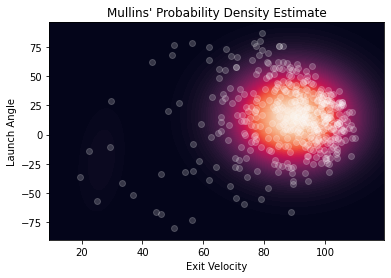

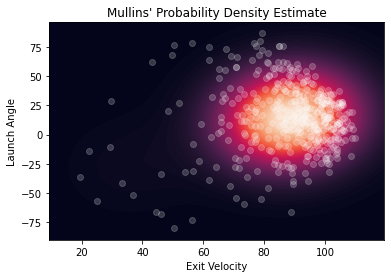

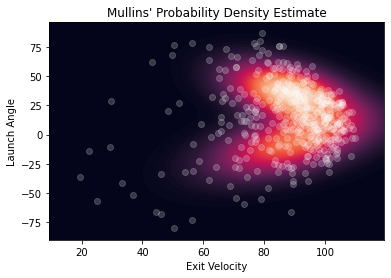

8


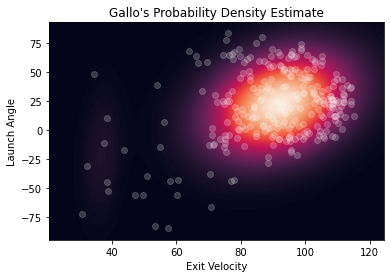

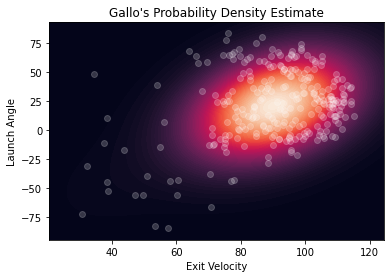

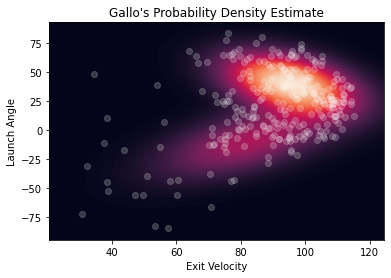

146


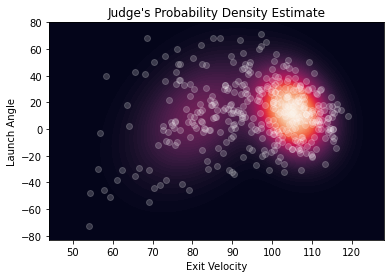

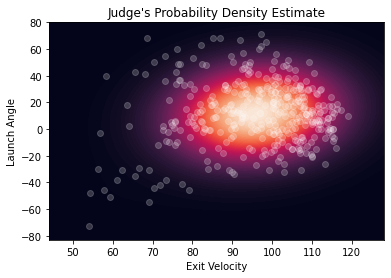

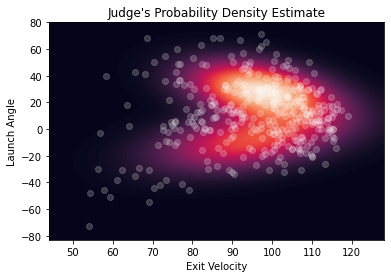

In [202]:
mult_mix_plot_split('mullins.csv')
mult_mix_plot_low_prob('mullins.csv')
mult_mix_plot_Kmeans('mullins.csv')

mult_mix_plot_split('gallo.csv')
mult_mix_plot_low_prob('gallo.csv')
mult_mix_plot_Kmeans('gallo.csv')

mult_mix_plot_split('judge.csv')
mult_mix_plot_low_prob('judge.csv')
mult_mix_plot_Kmeans('judge.csv')

In [203]:
#~8.5 seconds per comparison
print('Mullins v Gallo: ' + str(similarity_score('mullins.csv','gallo.csv')))
print('Mullins v Judge: ' + str(similarity_score('mullins.csv','judge.csv')))
print('Gallo v Judge: ' + str(similarity_score('gallo.csv','judge.csv')))
print('Judge v Gallo: ' + str(similarity_score('judge.csv','gallo.csv')))
print('Mullins v Mullins: ' + str(similarity_score('mullins.csv','mullins.csv')))

Mullins v Gallo: 1.0314
Mullins v Judge: 2.1461
Gallo v Judge: 1.2832
Judge v Gallo: 1.2832
Mullins v Mullins: 0.0


In [204]:
def bivariate_skew_norm_pdf_coords(coords, mu, covar_mat, shape):
    mult_dist = multivariate_normal(mean = mu, cov = covar_mat)
    heights = np.empty((coords.shape[0], coords.shape[1]))
    for i in range(coords.shape[0]):
        for j in range(coords.shape[1]):
            heights[i,j] = norm.cdf(np.dot(shape,coords[i,j,:].T))
    return 2 * mult_dist.pdf(coords) * heights

def bivariate_skew_norm_likelihood(data, mu1, mu2, var1, var2, covar, shape1, shape2):
    covar_mat = np.array([[var1,covar],[covar,var2]])
    mult_dist = multivariate_normal(mean = [mu1,mu2], cov = covar_mat)
    likelihood = 1
    for i in range (data.shape[0]):
        likelihood += np.log(2 * mult_dist.pdf(data[i,:]) * norm.cdf(np.dot([shape1,shape2],data[i,:].T)))
    return likelihood
        
def fit(data, mu1, mu2, var1, var2, covar, shape1, shape2):
    best_lik = -np.inf
    best_shape = [0,0]
    for i in np.arange(-1,1.01,0.25):
        for j in np.arange(-1,1,0.25):
            for k in np.arange(-1,1,0.25):
                for l in np.arange(-1,1,0.25):
                    lik = bivariate_skew_norm_likelihood(data, k, l, var1, var2, covar, i, j)
                    if lik > best_lik:
                        lik = best_lik
                        best_shape = [i,j]
                        best_mu = [k,l]
    return (best_shape, best_mu)
    

def bayes(file_name):
    
    #read in data
    data = pd.read_csv(file_name, header=None)
    data = data.dropna()
    data.columns = ['Exit Velocity','Launch Angle']

    #obtain data statistics
    cov_matrix = data.cov()
    velo_mean = data['Exit Velocity'].mean()
    angle_mean = data['Launch Angle'].mean()

    #normalize data
    data['Z - Exit Velocity'] = (data['Exit Velocity'] - velo_mean) / np.sqrt(np.array(cov_matrix)[0,0])
    data['Z - Launch Angle'] = (data['Launch Angle'] - angle_mean) / np.sqrt(np.array(cov_matrix)[1,1])
    z_cov_mat = data[['Z - Exit Velocity', 'Z - Launch Angle']].cov()

    dat = np.array(data[['Z - Exit Velocity', 'Z - Launch Angle']])
    print(bivariate_skew_norm_likelihood(dat, velo_mean, angle_mean, np.array(z_cov_mat)[0,0],np.array(z_cov_mat)[1,1], np.array(z_cov_mat)[0,1], 0, 0))

    #obtain coordinate mesh for heat map
    x_coords, y_coords = np.mgrid[data['Z - Exit Velocity'].min() - 2:data['Z - Exit Velocity'].max() + 2:.1, 
                    data['Z - Launch Angle'].min() - 2:data['Z - Launch Angle'].max() + 2:.1]

    X, Y = np.mgrid[data['Exit Velocity'].min() - 10:data['Exit Velocity'].max() + 10:x_coords.shape[0] + 0j, 
                    data['Launch Angle'].min() - 10:data['Launch Angle'].max() + 10:x_coords.shape[1] + 0j]
    
    #concatenate coordinates
    pos = np.dstack((x_coords,y_coords))
    print(pos.shape)
    
    #shape paramater
    params = fit(dat, velo_mean, angle_mean, np.array(z_cov_mat)[0,0],np.array(z_cov_mat)[1,1], np.array(z_cov_mat)[0,1], 0, 0)
    alpha = params[0]
    mu=params[1]
    print(alpha)
    print(mu)

    Z=bivariate_skew_norm_pdf_coords(pos, mu, z_cov_mat, alpha)


    #plot heat map
    plt.contourf(x_coords,y_coords,Z,levels=100,cmap='rocket')
    plt.scatter(x=data['Z - Exit Velocity'], y=data['Z - Launch Angle'], alpha=0.2, c='white')
    plt.show()
    return

def make_heat_map(file_name):

    name = file_name[:-4].upper()
    data = pd.read_csv(file_name, header=None)
    data = data.dropna()

    kde = KernelDensity(bandwidth = 1.0, kernel = 'gaussian').fit(data)
    samples = kde.sample(n_samples = 10000, random_state = 42)

    data = pd.DataFrame(data, columns=['Exit Velocity','Launch Angle'])
    samples = pd.DataFrame(samples, columns=['Exit Velocity','Launch Angle'])
    sns.set_theme(style="white")

    clip_min_x = min(samples['Exit Velocity']) - 10
    clip_max_x = max(samples['Exit Velocity']) + 10
    clip_min_y = min(samples['Launch Angle']) - 10
    clip_max_y = max(samples['Launch Angle']) + 10

    g = sns.JointGrid(data=samples, x='Exit Velocity', y='Launch Angle', space=0)
    g.plot_joint(sns.kdeplot,
             fill=True, cut = 20, clip = ((clip_min_x,clip_max_x),(clip_min_y,clip_max_y)),
             thresh=0, levels=100, cmap="rocket")
    g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)
    if (name[-1] == 'S'):
        g.fig.suptitle(name + "' HEAT MAP\n", y = 1.02)
    else: 
        g.fig.suptitle(name + "'S HEAT MAP\n", y = 1.02)
    


def similarity_score(file1, file2):
    data1 = pd.read_csv(file1, header=None)
    data1 = data1.dropna()
    kde1 = KernelDensity(bandwidth = 1.0, kernel = 'gaussian').fit(data1)

    data2 = pd.read_csv(file2, header=None)
    data2 = data2.dropna()
    kde2 = KernelDensity(bandwidth = 1.0, kernel = 'gaussian').fit(data2)

    min_exit_velocity = int(min(min(data1[0]),min(data2[0])) - 10)
    max_exit_velocity = int(max(max(data1[0]),max(data2[0])) + 10)
    min_launch_angle = int(min(min(data1[1]),min(data2[1])) - 10)
    max_launch_angle = int(max(max(data1[1]),max(data2[1])) + 10)

    score_sum = 0
    x_range = range(min_exit_velocity,max_exit_velocity)
    y_range = range(min_launch_angle,max_launch_angle)
    lattice_size = len(x_range) * len(y_range)
    for x in x_range:
        for y in y_range:
            score_sum += abs(kde1.score(np.array([x,y]).reshape(1,-1)) - kde2.score(np.array([x,y]).reshape(1,-1)))

    return np.ceil((score_sum / lattice_size) * 100) / 100 / 100